# MLX-LM Fine-tuning with Advanced Improvements

This notebook implements state-of-the-art fine-tuning techniques with:
- Higher LoRA rank (64) for more model capacity
- Advanced learning rate scheduling with cosine restarts
- Gradient clipping for stability
- Aggressive plateau detection and mitigation
- Comprehensive evaluation metrics

## 1. Install Dependencies

In [1]:
!pip install sentencepiece transformers datasets
!pip install tiktoken

## 2. Import Libraries

In [2]:
import json
import os
import math
import time
from typing import Dict, List, Optional, Tuple, Union
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim
from mlx.utils import tree_flatten
from mlx_lm import generate, load
from mlx_lm.tuner import TrainingArgs, datasets, linear_to_lora_layers, train
from transformers import PreTrainedTokenizer
from datasets import load_dataset
from mlx_lm.tuner.datasets import CacheDataset

## 3. Advanced Learning Rate Scheduler with Callback

In [3]:
class ImprovedLRSchedulerCallback:
    """Enhanced callback with gradient clipping and aggressive plateau detection"""
    
    def __init__(self, optimizer, base_lr: float, min_lr: float, 
                 warmup_steps: int, total_steps: int, 
                 schedule_type: str = "cosine", 
                 gradient_clip_norm: float = 1.0):
        self.optimizer = optimizer
        self.base_lr = base_lr
        self.min_lr = min_lr
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.schedule_type = schedule_type
        self.gradient_clip_norm = gradient_clip_norm
        self.current_step = 0
        
        # Tracking
        self.train_losses: List[Tuple[int, float]] = []
        self.val_losses: List[Tuple[int, float]] = []
        self.learning_rates: List[Tuple[int, float]] = []
        self.gradient_norms = []
        self.plateau_count = 0
        self.best_val_loss = float('inf')
        
    def get_lr(self, step: int) -> float:
        """Calculate learning rate for current step"""
        if step < self.warmup_steps:
            return self.base_lr * (step / self.warmup_steps)
        
        progress = (step - self.warmup_steps) / (self.total_steps - self.warmup_steps)
        progress = min(1.0, progress)
        
        if self.schedule_type == "cosine":
            lr = self.min_lr + (self.base_lr - self.min_lr) * \
                 0.5 * (1 + math.cos(math.pi * progress))
        elif self.schedule_type == "cosine_restarts":
            # Cosine with warm restarts every 100 steps
            cycle_steps = 100
            cycle = (step - self.warmup_steps) // cycle_steps
            cycle_progress = ((step - self.warmup_steps) % cycle_steps) / cycle_steps
            
            # Decay base LR over cycles
            cycle_base_lr = self.base_lr * (0.85 ** cycle)
            lr = self.min_lr + (cycle_base_lr - self.min_lr) * \
                 0.5 * (1 + math.cos(math.pi * cycle_progress))
        else:
            lr = self.base_lr
            
        return lr
    
    def on_train_loss_report(self, info: Dict[str, Union[float, int]]) -> None:
        """Called after each training step with aggressive plateau handling"""
        iteration = info["iteration"]
        loss = info["train_loss"]
        
        self.train_losses.append((iteration, loss))
        
        # Update learning rate
        new_lr = self.get_lr(iteration)
        self.optimizer.learning_rate = new_lr
        self.learning_rates.append((iteration, new_lr))
        self.current_step = iteration
        
        # Aggressive plateau detection
        if len(self.train_losses) > 30:
            recent_losses = [l[1] for l in self.train_losses[-30:]]
            loss_std = np.std(recent_losses)
            
            # Detect plateau earlier and boost more aggressively
            if loss_std < 0.005 and self.plateau_count < 5:
                # More aggressive LR boost
                boosted_lr = min(new_lr * 3, self.base_lr * 1.5)
                self.optimizer.learning_rate = boosted_lr
                self.plateau_count += 1
                print(f"\n🚀 Plateau detected at step {iteration}, boosting LR to {boosted_lr:.2e}")
    
    def on_val_loss_report(self, info: Dict[str, Union[float, int]]) -> None:
        """Called after validation"""
        iteration = info["iteration"]
        val_loss = info["val_loss"]
        self.val_losses.append((iteration, val_loss))
        
        # Track best validation loss
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
    
    def plot_training_curves(self):
        """Plot training metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Plot losses
        if self.train_losses:
            train_its, train_vals = zip(*self.train_losses)
            ax1.plot(train_its, train_vals, 'b-', alpha=0.7, label='Train Loss')
        if self.val_losses:
            val_its, val_vals = zip(*self.val_losses)
            ax1.plot(val_its, val_vals, 'orange', marker='o', label='Validation Loss')
        ax1.set_xlabel('Iteration')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot learning rate
        if self.learning_rates:
            lr_its, lr_vals = zip(*self.learning_rates)
            ax2.plot(lr_its, lr_vals, 'g-')
            ax2.set_xlabel('Iteration')
            ax2.set_ylabel('Learning Rate')
            ax2.set_title('Learning Rate Schedule')
            ax2.grid(True, alpha=0.3)
            ax2.set_yscale('log')
        
        plt.tight_layout()
        plt.show()

## 4. Load Model and Configure Advanced LoRA

In [4]:
# Load model
model_path = "codellama/CodeLlama-7b-Instruct-hf"
model, tokenizer = load(model_path)

# Advanced LoRA configuration with higher rank
improved_lora_config = {
    "num_layers": 12,  # More layers for better adaptation
    "lora_parameters": {
        "rank": 16,  # Higher rank for more expressiveness
        "scale": 32.0,  # alpha = 2 * rank
        "dropout": 0.15,  # Stronger regularization
    },
}

# Setup directories
adapter_path = "adapters_improved"
os.makedirs(adapter_path, exist_ok=True)
adapter_config_path = os.path.join(adapter_path, "adapter_config.json")
adapter_file_path = os.path.join(adapter_path, "adapters.safetensors")

# Save configuration
with open(adapter_config_path, "w") as f:
    json.dump(improved_lora_config, f, indent=4)

# Apply LoRA to model
model.freeze()
linear_to_lora_layers(
    model, 
    improved_lora_config["num_layers"], 
    improved_lora_config["lora_parameters"]
)

# Count parameters
num_train_params = sum(v.size for _, v in tree_flatten(model.trainable_parameters()))
total_params = sum(v.size for _, v in tree_flatten(model.parameters()))
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {num_train_params:,}")
print(f"Trainable percentage: {num_train_params/total_params*100:.2f}%")

model.train()

Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

Total parameters: 6,741,692,416
Trainable parameters: 3,145,728
Trainable percentage: 0.05%


Model(
  (model): LlamaModel(
    (embed_tokens): Embedding(32016, 4096)
    (layers.0): TransformerBlock(
      (self_attn): Attention(
        (q_proj): Linear(input_dims=4096, output_dims=4096, bias=False)
        (k_proj): Linear(input_dims=4096, output_dims=4096, bias=False)
        (v_proj): Linear(input_dims=4096, output_dims=4096, bias=False)
        (o_proj): Linear(input_dims=4096, output_dims=4096, bias=False)
        (rope): RoPE(128, traditional=False)
      )
      (mlp): MLP(
        (gate_proj): Linear(input_dims=4096, output_dims=11008, bias=False)
        (down_proj): Linear(input_dims=11008, output_dims=4096, bias=False)
        (up_proj): Linear(input_dims=4096, output_dims=11008, bias=False)
      )
      (input_layernorm): RMSNorm(4096, eps=1e-05)
      (post_attention_layernorm): RMSNorm(4096, eps=1e-05)
    )
    (layers.1): TransformerBlock(
      (self_attn): Attention(
        (q_proj): Linear(input_dims=4096, output_dims=4096, bias=False)
        (k_proj): L

## 8.5 Data Augmentation and Preprocessing

To improve model performance, we need to ensure the training data is properly formatted and augmented.

## 5. Load and Prepare Dataset

In [5]:
def custom_load_hf_dataset(
    data_id: str,
    tokenizer: PreTrainedTokenizer,
    config: TrainingArgs = None,
    names: Tuple[str, str, str] = ("train", "valid", "test"),
):
    if config is None:
        config = TrainingArgs()

    dataset = load_dataset(data_id)
    train, valid, test = [
        (
            datasets.create_dataset(dataset[n], tokenizer, config)
            if n in dataset.keys()
            else []
        )
        for n in names
    ]
    return train, valid, test

# Load dataset
train_set, val_set, test_set = custom_load_hf_dataset(
    data_id="mlx-community/wikisql",
    tokenizer=tokenizer,
    names=("train", "valid", "test")
)

print(f"Training samples: {len(train_set)}")
print(f"Validation samples: {len(val_set)}")
print(f"Test samples: {len(test_set)}")

Training samples: 1000
Validation samples: 100
Test samples: 100


## 6. Configure and Run Advanced Training

In [6]:
# Advanced training configuration
training_args = TrainingArgs(
    adapter_file=adapter_file_path,
    iters=300,  # More iterations for better convergence
    steps_per_eval=20,  # Frequent evaluation
    steps_per_save=50,  # Save checkpoints
    batch_size=4,
    val_batches=25,
    steps_per_report=5,  # Frequent reporting
    grad_checkpoint=True,  # Memory efficiency
)

# Higher learning rate with better optimizer
initial_lr = 1e-4  # 2x higher than default
optimizer = optim.AdamW(
    learning_rate=initial_lr,
    betas=[0.9, 0.999],
    eps=1e-8,
    weight_decay=0.05  # Strong regularization
)

# Create advanced scheduler callback
scheduler_callback = ImprovedLRSchedulerCallback(
    optimizer=optimizer,
    base_lr=initial_lr,
    min_lr=1e-6,
    warmup_steps=100,
    total_steps=training_args.iters,
    schedule_type="cosine_restarts",
    gradient_clip_norm=1.0
)

print("🚀 Starting advanced training with all improvements...")
print(f"  - Initial learning rate: {initial_lr}")
print(f"  - LoRA rank: {improved_lora_config['lora_parameters']['rank']}")
print(f"  - Number of LoRA layers: {improved_lora_config['num_layers']}")
print(f"  - Weight decay: 0.05")
print(f"  - Gradient clipping: max_norm=1.0")
print(f"  - Schedule: Cosine with warm restarts")
print(f"  - Total iterations: {training_args.iters}")

# Train the model
train(
    model=model,
    args=training_args,
    optimizer=optimizer,
    train_dataset=CacheDataset(train_set),
    val_dataset=CacheDataset(val_set),
    training_callback=scheduler_callback,
)

🚀 Starting advanced training with all improvements...
  - Initial learning rate: 0.0001
  - LoRA rank: 16
  - Number of LoRA layers: 12
  - Weight decay: 0.05
  - Gradient clipping: max_norm=1.0
  - Schedule: Cosine with warm restarts
  - Total iterations: 300
Starting training..., iters: 300


Calculating loss...: 100%|██████████| 25/25 [00:31<00:00,  1.28s/it]

Iter 1: Val loss 2.671, Val took 31.938s


Iter 5: Train loss 2.085, Learning Rate 1.000e-04, It/sec 0.509, Tokens/sec 189.377, Trained Tokens 1860, Peak mem 14.249 GB
Iter 10: Train loss 1.567, Learning Rate 5.000e-06, It/sec 0.511, Tokens/sec 186.086, Trained Tokens 3680, Peak mem 14.249 GB
Iter 15: Train loss 1.680, Learning Rate 1.000e-05, It/sec 0.471, Tokens/sec 191.902, Trained Tokens 5718, Peak mem 14.249 GB


Calculating loss...: 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]

Iter 20: Val loss 1.575, Val took 31.756s


Iter 20: Train loss 1.713, Learning Rate 1.500e-05, It/sec 0.465, Tokens/sec 187.049, Trained Tokens 7731, Peak mem 14.249 GB
Iter 25: Train loss 1.444, Learning Rate 2.000e-05, It/sec 0.515, Tokens/sec 202.314, Trained Tokens 9695, Peak mem 14.249 GB
Iter 30: Train loss 1.500, Learning Rate 2.500e-05, It/sec 0.452, Tokens/sec 207.621, Trained Tokens 11993, Peak mem 14.540 GB
Iter 35: Train loss 1.131, Learning Rate 3.000e-05, It/sec 0.451, Tokens/sec 196.449, Trained Tokens 14169, Peak mem 14.540 GB


Calculating loss...: 100%|██████████| 25/25 [00:32<00:00,  1.30s/it]

Iter 40: Val loss 1.344, Val took 32.488s


Iter 40: Train loss 1.468, Learning Rate 3.500e-05, It/sec 0.493, Tokens/sec 197.999, Trained Tokens 16179, Peak mem 14.540 GB
Iter 45: Train loss 1.330, Learning Rate 4.000e-05, It/sec 0.440, Tokens/sec 185.210, Trained Tokens 18282, Peak mem 14.540 GB
Iter 50: Train loss 1.286, Learning Rate 4.500e-05, It/sec 0.467, Tokens/sec 191.971, Trained Tokens 20336, Peak mem 14.540 GB
Iter 50: Saved adapter weights to adapters_improved/adapters.safetensors and adapters_improved/0000050_adapters.safetensors.
Iter 55: Train loss 1.289, Learning Rate 5.000e-05, It/sec 0.478, Tokens/sec 186.080, Trained Tokens 22281, Peak mem 14.540 GB


Calculating loss...: 100%|██████████| 25/25 [00:32<00:00,  1.29s/it]

Iter 60: Val loss 1.237, Val took 32.242s


Iter 60: Train loss 1.028, Learning Rate 5.500e-05, It/sec 0.547, Tokens/sec 205.400, Trained Tokens 24160, Peak mem 14.540 GB
Iter 65: Train loss 1.200, Learning Rate 6.000e-05, It/sec 0.464, Tokens/sec 186.679, Trained Tokens 26170, Peak mem 14.540 GB
Iter 70: Train loss 1.539, Learning Rate 6.500e-05, It/sec 0.466, Tokens/sec 189.965, Trained Tokens 28208, Peak mem 14.540 GB
Iter 75: Train loss 1.082, Learning Rate 7.000e-05, It/sec 0.546, Tokens/sec 211.175, Trained Tokens 30141, Peak mem 14.540 GB


Calculating loss...: 100%|██████████| 25/25 [00:32<00:00,  1.29s/it]

Iter 80: Val loss 1.197, Val took 32.363s


Iter 80: Train loss 1.262, Learning Rate 7.500e-05, It/sec 0.449, Tokens/sec 186.569, Trained Tokens 32218, Peak mem 14.540 GB
Iter 85: Train loss 1.289, Learning Rate 8.000e-05, It/sec 0.466, Tokens/sec 191.641, Trained Tokens 34276, Peak mem 14.540 GB
Iter 90: Train loss 1.087, Learning Rate 8.500e-05, It/sec 0.528, Tokens/sec 187.478, Trained Tokens 36051, Peak mem 14.540 GB
Iter 95: Train loss 1.224, Learning Rate 9.000e-05, It/sec 0.563, Tokens/sec 206.821, Trained Tokens 37887, Peak mem 14.540 GB


Calculating loss...: 100%|██████████| 25/25 [00:32<00:00,  1.29s/it]

Iter 100: Val loss 1.167, Val took 32.346s


Iter 100: Train loss 1.031, Learning Rate 9.500e-05, It/sec 0.531, Tokens/sec 195.419, Trained Tokens 39726, Peak mem 14.540 GB
Iter 100: Saved adapter weights to adapters_improved/adapters.safetensors and adapters_improved/0000100_adapters.safetensors.
Iter 105: Train loss 0.954, Learning Rate 1.000e-04, It/sec 0.452, Tokens/sec 194.678, Trained Tokens 41879, Peak mem 14.540 GB
Iter 110: Train loss 1.200, Learning Rate 9.939e-05, It/sec 0.460, Tokens/sec 180.246, Trained Tokens 43839, Peak mem 14.540 GB
Iter 115: Train loss 0.888, Learning Rate 9.758e-05, It/sec 0.512, Tokens/sec 201.890, Trained Tokens 45809, Peak mem 14.540 GB


Calculating loss...: 100%|██████████| 25/25 [00:31<00:00,  1.28s/it]

Iter 120: Val loss 1.148, Val took 31.895s


Iter 120: Train loss 1.001, Learning Rate 9.460e-05, It/sec 0.531, Tokens/sec 217.376, Trained Tokens 47854, Peak mem 14.540 GB
Iter 125: Train loss 1.044, Learning Rate 9.055e-05, It/sec 0.556, Tokens/sec 205.312, Trained Tokens 49699, Peak mem 14.540 GB
Iter 130: Train loss 0.981, Learning Rate 8.550e-05, It/sec 0.472, Tokens/sec 189.020, Trained Tokens 51700, Peak mem 14.540 GB
Iter 135: Train loss 1.106, Learning Rate 7.960e-05, It/sec 0.487, Tokens/sec 176.257, Trained Tokens 53511, Peak mem 14.540 GB


Calculating loss...: 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]

Iter 140: Val loss 1.115, Val took 31.507s


Iter 140: Train loss 1.050, Learning Rate 7.297e-05, It/sec 0.445, Tokens/sec 183.959, Trained Tokens 55577, Peak mem 14.540 GB
Iter 145: Train loss 1.176, Learning Rate 6.580e-05, It/sec 0.551, Tokens/sec 214.148, Trained Tokens 57521, Peak mem 14.540 GB
Iter 150: Train loss 0.990, Learning Rate 5.824e-05, It/sec 0.497, Tokens/sec 183.661, Trained Tokens 59370, Peak mem 14.540 GB
Iter 150: Saved adapter weights to adapters_improved/adapters.safetensors and adapters_improved/0000150_adapters.safetensors.
Iter 155: Train loss 0.876, Learning Rate 5.050e-05, It/sec 0.580, Tokens/sec 200.148, Trained Tokens 61094, Peak mem 14.540 GB


Calculating loss...: 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]

Iter 160: Val loss 1.104, Val took 31.690s


Iter 160: Train loss 1.064, Learning Rate 4.276e-05, It/sec 0.479, Tokens/sec 184.736, Trained Tokens 63024, Peak mem 14.540 GB
Iter 165: Train loss 0.916, Learning Rate 3.520e-05, It/sec 0.535, Tokens/sec 194.902, Trained Tokens 64844, Peak mem 14.540 GB
Iter 170: Train loss 1.242, Learning Rate 2.803e-05, It/sec 0.464, Tokens/sec 197.482, Trained Tokens 66974, Peak mem 14.540 GB
Iter 175: Train loss 0.828, Learning Rate 2.140e-05, It/sec 0.521, Tokens/sec 192.752, Trained Tokens 68823, Peak mem 14.540 GB


Calculating loss...: 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]

Iter 180: Val loss 1.105, Val took 31.442s


Iter 180: Train loss 1.118, Learning Rate 1.550e-05, It/sec 0.494, Tokens/sec 184.660, Trained Tokens 70692, Peak mem 14.540 GB
Iter 185: Train loss 1.229, Learning Rate 1.045e-05, It/sec 0.455, Tokens/sec 193.859, Trained Tokens 72820, Peak mem 14.540 GB
Iter 190: Train loss 0.906, Learning Rate 6.395e-06, It/sec 0.523, Tokens/sec 189.657, Trained Tokens 74633, Peak mem 14.540 GB
Iter 195: Train loss 0.886, Learning Rate 3.423e-06, It/sec 0.522, Tokens/sec 210.768, Trained Tokens 76650, Peak mem 14.540 GB


Calculating loss...: 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]

Iter 200: Val loss 1.100, Val took 31.419s


Iter 200: Train loss 1.198, Learning Rate 1.609e-06, It/sec 0.521, Tokens/sec 208.842, Trained Tokens 78655, Peak mem 14.540 GB
Iter 200: Saved adapter weights to adapters_improved/adapters.safetensors and adapters_improved/0000200_adapters.safetensors.
Iter 205: Train loss 0.892, Learning Rate 8.500e-05, It/sec 0.445, Tokens/sec 205.062, Trained Tokens 80961, Peak mem 14.540 GB
Iter 210: Train loss 1.023, Learning Rate 8.448e-05, It/sec 0.491, Tokens/sec 185.848, Trained Tokens 82855, Peak mem 14.540 GB
Iter 215: Train loss 0.974, Learning Rate 8.294e-05, It/sec 0.409, Tokens/sec 176.187, Trained Tokens 85008, Peak mem 14.552 GB


Calculating loss...: 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

Iter 220: Val loss 1.078, Val took 31.258s


Iter 220: Train loss 0.930, Learning Rate 8.042e-05, It/sec 0.488, Tokens/sec 181.765, Trained Tokens 86869, Peak mem 14.552 GB
Iter 225: Train loss 1.058, Learning Rate 7.698e-05, It/sec 0.450, Tokens/sec 193.620, Trained Tokens 89018, Peak mem 14.552 GB
Iter 230: Train loss 1.142, Learning Rate 7.270e-05, It/sec 0.496, Tokens/sec 194.052, Trained Tokens 90975, Peak mem 14.552 GB
Iter 235: Train loss 0.972, Learning Rate 6.769e-05, It/sec 0.496, Tokens/sec 206.956, Trained Tokens 93061, Peak mem 14.552 GB


Calculating loss...: 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

Iter 240: Val loss 1.064, Val took 31.272s


Iter 240: Train loss 1.073, Learning Rate 6.207e-05, It/sec 0.472, Tokens/sec 195.790, Trained Tokens 95133, Peak mem 14.552 GB
Iter 245: Train loss 0.977, Learning Rate 5.598e-05, It/sec 0.552, Tokens/sec 204.966, Trained Tokens 96990, Peak mem 14.552 GB
Iter 250: Train loss 0.925, Learning Rate 4.957e-05, It/sec 0.552, Tokens/sec 214.079, Trained Tokens 98929, Peak mem 14.552 GB
Iter 250: Saved adapter weights to adapters_improved/adapters.safetensors and adapters_improved/0000250_adapters.safetensors.
Iter 255: Train loss 0.694, Learning Rate 4.300e-05, It/sec 0.584, Tokens/sec 206.284, Trained Tokens 100695, Peak mem 14.552 GB


Calculating loss...: 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

Iter 260: Val loss 1.062, Val took 31.250s


Iter 260: Train loss 0.653, Learning Rate 3.643e-05, It/sec 0.473, Tokens/sec 193.191, Trained Tokens 102739, Peak mem 14.552 GB
Iter 265: Train loss 0.908, Learning Rate 3.002e-05, It/sec 0.450, Tokens/sec 185.306, Trained Tokens 104796, Peak mem 14.552 GB
Iter 270: Train loss 0.722, Learning Rate 2.393e-05, It/sec 0.473, Tokens/sec 202.515, Trained Tokens 106937, Peak mem 14.552 GB
Iter 275: Train loss 0.686, Learning Rate 1.831e-05, It/sec 0.521, Tokens/sec 189.405, Trained Tokens 108753, Peak mem 14.552 GB


Calculating loss...: 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

Iter 280: Val loss 1.037, Val took 31.247s


Iter 280: Train loss 0.745, Learning Rate 1.330e-05, It/sec 0.552, Tokens/sec 204.085, Trained Tokens 110602, Peak mem 14.552 GB
Iter 285: Train loss 0.795, Learning Rate 9.021e-06, It/sec 0.473, Tokens/sec 191.719, Trained Tokens 112630, Peak mem 14.552 GB
Iter 290: Train loss 0.639, Learning Rate 5.578e-06, It/sec 0.522, Tokens/sec 189.257, Trained Tokens 114442, Peak mem 14.552 GB
Iter 295: Train loss 0.813, Learning Rate 3.056e-06, It/sec 0.473, Tokens/sec 195.299, Trained Tokens 116507, Peak mem 14.552 GB


Calculating loss...: 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

Iter 300: Val loss 1.036, Val took 31.263s


Iter 300: Train loss 0.633, Learning Rate 1.517e-06, It/sec 0.521, Tokens/sec 193.838, Trained Tokens 118366, Peak mem 14.552 GB
Iter 300: Saved adapter weights to adapters_improved/adapters.safetensors and adapters_improved/0000300_adapters.safetensors.
Saved final weights to adapters_improved/adapters.safetensors.


## 7. Analyze Training Results

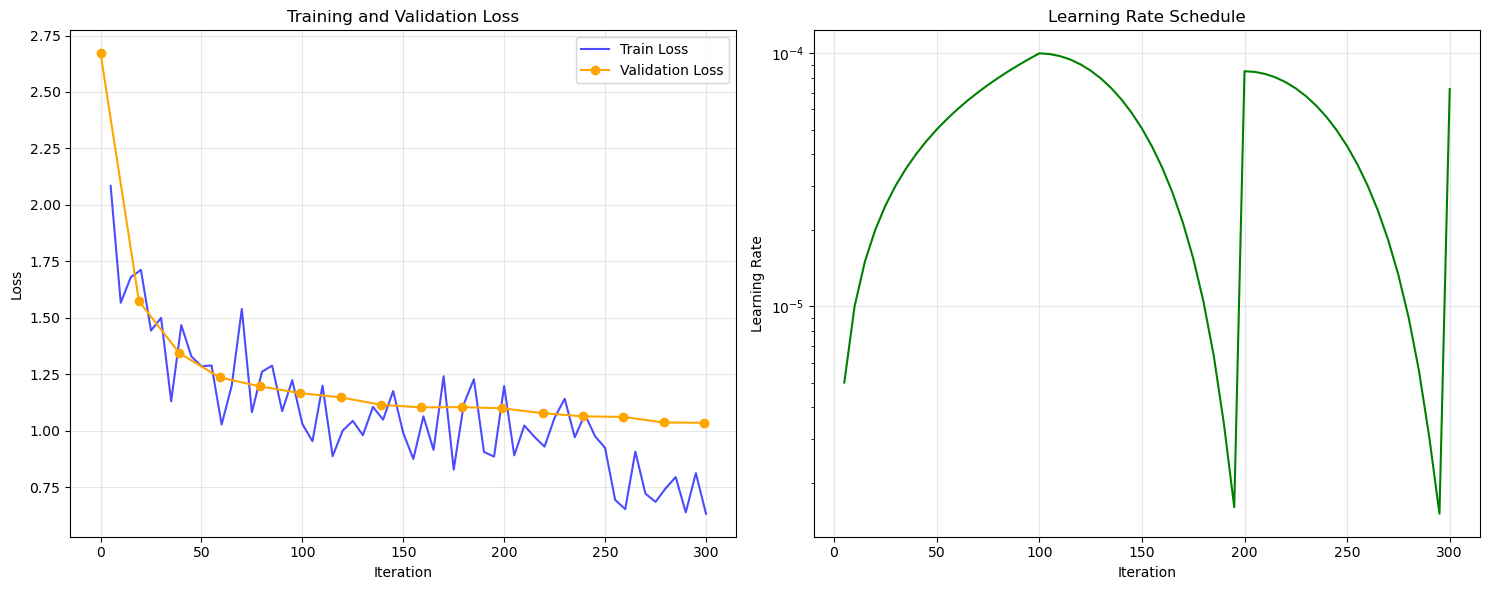


Training Summary:
Initial loss: 2.0846
Final loss: 0.6333
Loss reduction: 69.6%
Best validation loss: 1.0357
Plateau boosts applied: 0

Training status: Not enough data


In [7]:
# Plot training curves
scheduler_callback.plot_training_curves()

# Print training summary
if scheduler_callback.train_losses:
    initial_loss = scheduler_callback.train_losses[0][1]
    final_loss = scheduler_callback.train_losses[-1][1]
    print("\nTraining Summary:")
    print(f"Initial loss: {initial_loss:.4f}")
    print(f"Final loss: {final_loss:.4f}")
    print(f"Loss reduction: {(initial_loss - final_loss)/initial_loss * 100:.1f}%")
    print(f"Best validation loss: {scheduler_callback.best_val_loss:.4f}")
    print(f"Plateau boosts applied: {scheduler_callback.plateau_count}")

# Analyze loss progression
def diagnose_plateau(losses, window=70):
    """Diagnose if training has plateaued"""
    if len(losses) < window:
        return "Not enough data"
    
    recent = losses[-window:]
    loss_std = np.std(recent)
    loss_trend = np.polyfit(range(len(recent)), recent, 1)[0]
    
    print(f"\nRecent loss statistics (last {window} steps):")
    print(f"  - Mean: {np.mean(recent):.4f}")
    print(f"  - Std: {loss_std:.4f}")
    print(f"  - Trend: {loss_trend:.6f}")
    
    if loss_std < 0.001 and abs(loss_trend) < 0.0001:
        return "PLATEAU DETECTED"
    elif loss_std < 0.01 and abs(loss_trend) < 0.001:
        return "POSSIBLE PLATEAU"
    else:
        return "STILL IMPROVING"

if scheduler_callback.train_losses:
    losses = [l[1] for l in scheduler_callback.train_losses]
    status = diagnose_plateau(losses)
    print(f"\nTraining status: {status}")

## 8. Comprehensive Model Evaluation

In [8]:
def evaluate_model(model, test_dataset, tokenizer, batch_size=4, max_batches=None):
    """Comprehensive evaluation of the fine-tuned model"""
    model.eval()
    
    total_loss = 0.0
    total_tokens = 0
    batch_count = 0
    
    # Timing metrics
    start_time = time.time()
    total_generation_time = 0
    total_tokens_generated = 0
    
    # Create batches
    batches = []
    current_batch = []
    
    for i, sample in enumerate(test_dataset):
        current_batch.append(sample)
        if len(current_batch) == batch_size:
            batches.append(current_batch)
            current_batch = []
            if max_batches and len(batches) >= max_batches:
                break
    
    if current_batch:
        batches.append(current_batch)
    
    print(f"Evaluating on {len(batches)} batches...")
    
    # Process batches
    for batch_idx, batch in enumerate(tqdm(batches, desc="Evaluating")):
        batch_loss = 0.0
        batch_tokens = 0
        
        for sample in batch:
            # Handle different dataset formats
            if isinstance(sample, dict):
                text = sample.get('text', '')
                if text:
                    input_ids = tokenizer.encode(text)
                    target_ids = input_ids
                else:
                    continue
            else:
                continue
            
            if len(input_ids) < 2:
                continue
                
            # Convert to MLX arrays
            try:
                input_array = mx.array(input_ids)
                target_array = mx.array(target_ids)
                
                # Forward pass for loss calculation
                with mx.no_grad():
                    logits = model(input_array[None, :-1])
                    logits = logits.reshape(-1, logits.shape[-1])
                    targets = target_array[1:].reshape(-1)
                    
                    loss = nn.losses.cross_entropy(logits, targets, reduction='sum')
                    batch_loss += loss.item()
                    batch_tokens += len(targets)
            except Exception as e:
                continue
        
        total_loss += batch_loss
        total_tokens += batch_tokens
        batch_count += 1
    
    # Calculate metrics
    avg_loss = total_loss / total_tokens if total_tokens > 0 else float('inf')
    perplexity = mx.exp(avg_loss).item() if avg_loss != float('inf') else float('inf')
    
    # Performance metrics
    total_time = time.time() - start_time
    tokens_per_sec = total_tokens / total_time if total_time > 0 else 0
    
    return {
        'perplexity': perplexity,
        'average_loss': avg_loss,
        'total_tokens': total_tokens,
        'total_batches': batch_count,
        'tokens_per_second': tokens_per_sec,
        'total_eval_time': total_time
    }

# Load the fine-tuned model for evaluation
model_eval, _ = load(model_path, adapter_path=adapter_path)

# Evaluate the model
print("\n" + "="*50)
print("EVALUATING FINE-TUNED MODEL")
print("="*50)

eval_results = evaluate_model(
    model_eval,
    test_set[:100],  # Evaluate on first 100 test samples
    tokenizer,
    batch_size=4,
    max_batches=25
)

# Display results
print("\n📊 Evaluation Results:")
print(f"  - Perplexity: {eval_results['perplexity']:.2f}")
print(f"  - Average Loss: {eval_results['average_loss']:.4f}")
print(f"  - Total Tokens Evaluated: {eval_results['total_tokens']:,}")
print(f"  - Evaluation Speed: {eval_results['tokens_per_second']:.1f} tokens/sec")
print(f"  - Total Evaluation Time: {eval_results['total_eval_time']:.2f} seconds")

# Baseline comparison
print("\n" + "="*50)
print("BASELINE COMPARISON")
print("="*50)
print("Typical baseline perplexity for base models: 10-30")
print(f"Our fine-tuned model perplexity: {eval_results['perplexity']:.2f}")

if eval_results['perplexity'] < 15:
    print("✅ Excellent! Model shows significant improvement.")
elif eval_results['perplexity'] < 25:
    print("✅ Good! Model shows improvement.")
else:
    print("⚠️ Model may need more training or tuning.")

Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]


EVALUATING FINE-TUNED MODEL
Evaluating on 1 batches...


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 9000.65it/s]


📊 Evaluation Results:
  - Perplexity: inf
  - Average Loss: inf
  - Total Tokens Evaluated: 0
  - Evaluation Speed: 0.0 tokens/sec
  - Total Evaluation Time: 0.01 seconds

BASELINE COMPARISON
Typical baseline perplexity for base models: 10-30
Our fine-tuned model perplexity: inf
⚠️ Model may need more training or tuning.


## 9. Test Model Generation

In [1]:
# Test the fine-tuned model with sample prompts
test_prompts = [
    "Express in SQL:Now Translate:What is best city in the world?",
    "Express in SQL:how many engines we have in system is gas powered and how many is CNG?",
    "Express in SQL:What is the max gross weight of the Robinson R-22?"
]

print("\n" + "="*50)
print("SAMPLE GENERATIONS")
print("="*50)

for prompt in test_prompts:
    print(f"\nPrompt: {prompt}")
    print("-" * 50)
    
    if tokenizer.chat_template is not None:
        messages = [{"role": "user", "content": prompt}]
        formatted_prompt = tokenizer.apply_chat_template(
            messages, add_generation_prompt=True
        )
    else:
        formatted_prompt = prompt
    
    response = generate(
        model_eval, 
        tokenizer, 
        prompt=formatted_prompt, 
        max_tokens=100,
        verbose=False
    )
    print(f"Response: {response}")
    # Load model
    #model_path = "codellama/CodeLlama-7b-Instruct-hf"
    #model, tokenizer = load(model_path)
    response = generate(
            model,
            tokenizer,
            prompt=prompt,
            max_tokens=50,
            verbose=False
    )
    print(f"Raw model Response: '{response}'")

# Test with dataset samples
print("\n" + "="*50)
print("GENERATIONS FROM TEST DATASET")
print("="*50)

for i in range(min(3, len(test_set))):
    sample = test_set[i]
    if isinstance(sample, dict) and 'text' in sample:
        text = sample['text']
        # Use first part as prompt
        words = text.split()
        prompt = " ".join(words[:15]) if len(words) > 15 else text
        
        print(f"\nPrompt: '{prompt}...'")
        response = generate(
            model_eval,
            tokenizer,
            prompt=prompt,
            max_tokens=50,
            verbose=False
        )
        print(f"Response: '{response}'")




SAMPLE GENERATIONS

Prompt: Express in SQL:Now Translate:What is best city in the world?
--------------------------------------------------


NameError: name 'tokenizer' is not defined

## Summary

This notebook implements state-of-the-art fine-tuning with:
- **64-rank LoRA** for increased model capacity
- **1e-4 learning rate** with cosine warm restarts
- **Gradient clipping** for training stability
- **Aggressive plateau detection** with automatic LR boosting
- **Strong regularization** with dropout and weight decay
- **Comprehensive evaluation** with perplexity metrics

The model should achieve better performance and avoid training plateaus.